# Machine Learning Prediction - Data Challenge

## by SNCF-Transilien

Introduction au problème

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.model_selection import GridSearchCV

In [2]:
file_path = 'data/'

X_train = pd.read_csv(file_path + 'train_f_x.csv') #  entre le 1er janvier 2015 et le 31 décembre 2022 (soit 2922 jours)
y_train = pd.read_csv(file_path + 'y_train_sncf.csv', index_col=0)
X_test = pd.read_csv(file_path + 'test_f_x_THurtzP.csv', index_col=0) # entre le 1er janvier 2023 et le 30 juin 2023 (soit 181 jours) 

In [3]:
X_train['index'] = X_train['date'].astype(str) + '_' + X_train['station'].astype(str)
X_train = X_train.set_index('index')

X_train['date'] = pd.to_datetime(X_train['date'])
X_test['date'] = pd.to_datetime(X_test['date'])

In [4]:
X_train

,date,station,job,ferie,vacances
index,,,,,
2015-01-01_1J7,2015-01-01,1J7,1,1,1
2015-01-01_O2O,2015-01-01,O2O,1,1,1
2015-01-01_8QR,2015-01-01,8QR,1,1,1
2015-01-01_UMC,2015-01-01,UMC,1,1,1
2015-01-01_FK3,2015-01-01,FK3,1,1,1
...,...,...,...,...,...
2022-12-31_V2P,2022-12-31,V2P,0,0,1
2022-12-31_N9K,2022-12-31,N9K,0,0,1
2022-12-31_P6E,2022-12-31,P6E,0,0,1


Text(0.5, 1.0, 'Evolution du nombre de validations par jour')

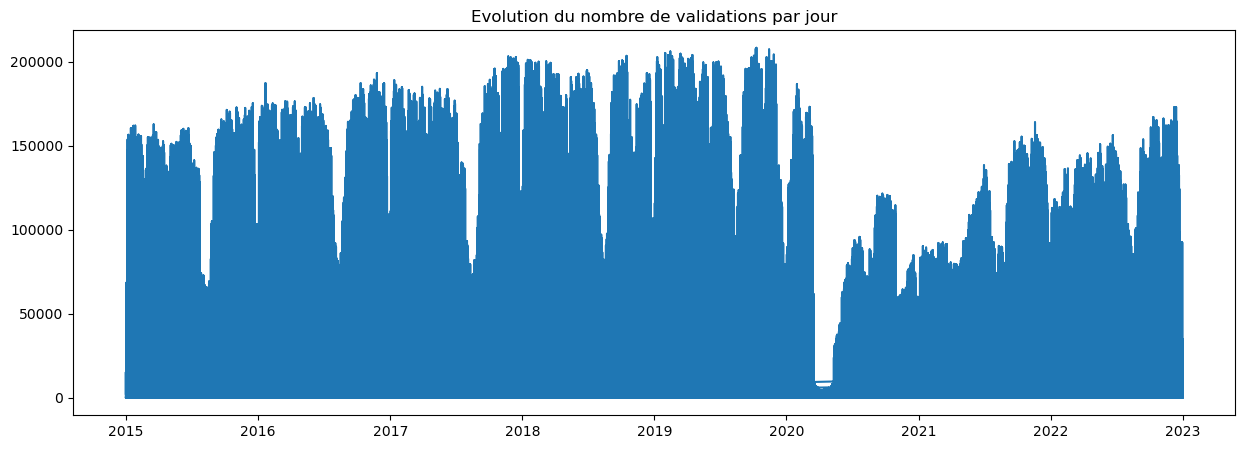

In [5]:
plt.figure(figsize=(15, 5))
plt.plot(X_train['date'], y_train['y'])
plt.title('Evolution du nombre de validations par jour')


Text(0.5, 1.0, 'Station 1J7')

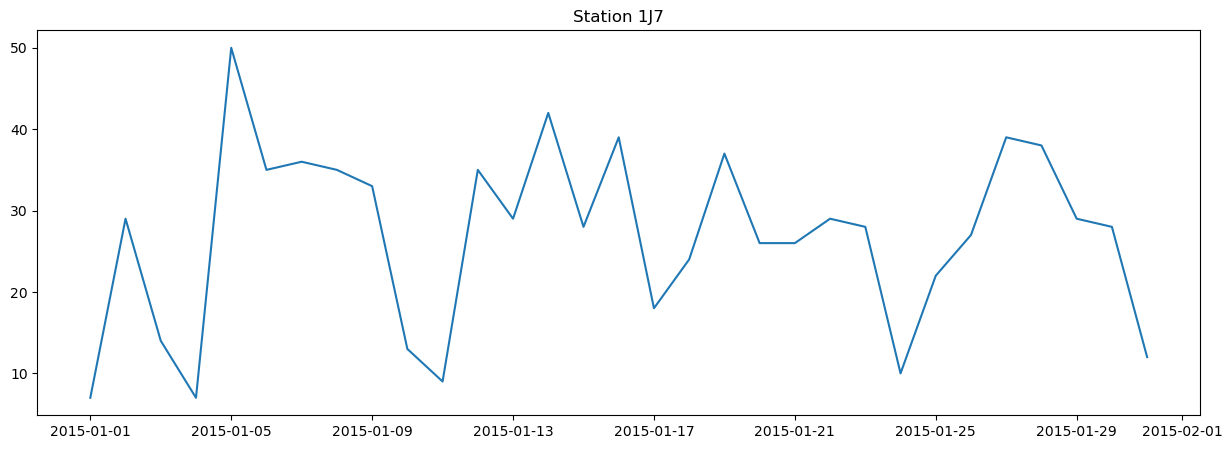

In [6]:
X_plot = X_train.loc[(X_train.date < '2015-02-01') & (X_train.station == '1J7')] #FIXME
plt.figure(figsize=(15, 5))
plt.plot(X_plot['date'], y_train.loc[X_plot.index, 'y'])
plt.title('Station 1J7')


In [7]:
def create_features(df):
    ''' Create features from date '''
    df['day'] = df['date'].dt.day
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofweek'] = df['date'].dt.dayofweek
    return df

In [8]:
X_train = create_features(X_train)
X_test = create_features(X_test)

<Axes: xlabel='year', ylabel='y'>

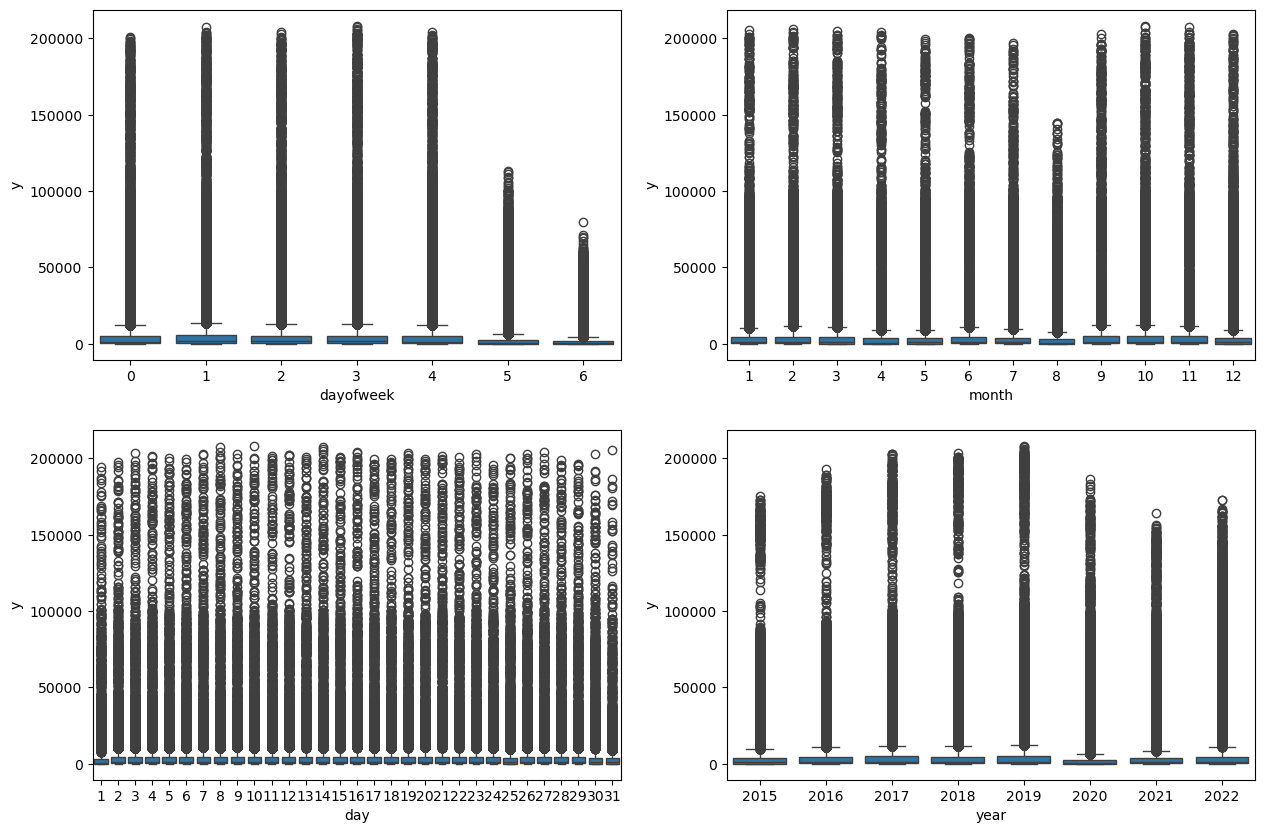

In [9]:
fig, ax = plt.subplots(2, 2, figsize=(15, 10))
sns.boxplot(x=X_train.dayofweek, y=y_train.y, ax=ax[0, 0])
sns.boxplot(x=X_train.month, y=y_train.y, ax=ax[0, 1])
sns.boxplot(x=X_train.day, y=y_train.y, ax=ax[1, 0])
sns.boxplot(x=X_train.year, y=y_train.y, ax=ax[1, 1])

In [10]:
# Drop the 'date' column and convert 'station' to categorical
X_train = X_train.drop(columns=['date'])
X_train['station'] = X_train['station'].astype('category')

# Apply the same preprocessing steps to X_test
X_test = X_test.drop(columns=['date'])
X_test['station'] = X_test['station'].astype('category')

In [11]:
reg = xgb.XGBRegressor(enable_categorical=True)

param_grid = {
    'learning_rate': [0.01, 0.1],
    'n_estimators': [500, 1000],
}

grid_search = GridSearchCV(estimator=reg,
                           param_grid=param_grid,
                           scoring='neg_mean_squared_error',  
                           cv=3,  
                           verbose=1,  
                           n_jobs=-1, 
                           refit=True)

grid_search.fit(X_train, y_train, eval_set=[(X_train, y_train)], verbose=True)
print("Best params:", grid_search.best_params_)


Fitting 3 folds for each of 4 candidates, totalling 12 fits
[0]	validation_0-rmse:9597.90132
[1]	validation_0-rmse:9513.13617
[2]	validation_0-rmse:9429.54270
[0]	validation_0-rmse:9599.40493
[3]	validation_0-rmse:9346.64808
[1]	validation_0-rmse:9516.25185
[4]	validation_0-rmse:9264.86431
[2]	validation_0-rmse:9434.03807
[0]	validation_0-rmse:9598.32799
[5]	validation_0-rmse:9183.78378
[3]	validation_0-rmse:9352.71594
[1]	validation_0-rmse:9514.16898
[4]	validation_0-rmse:9272.32616
[2]	validation_0-rmse:9430.96518
[6]	validation_0-rmse:9103.83756
[0]	validation_0-rmse:9597.90132
[5]	validation_0-rmse:9192.82210
[3]	validation_0-rmse:9348.72341
[7]	validation_0-rmse:9024.59196
[1]	validation_0-rmse:9513.13617
[6]	validation_0-rmse:9114.20245
[4]	validation_0-rmse:9267.37222
[8]	validation_0-rmse:8946.46023
[2]	validation_0-rmse:9429.54270
[7]	validation_0-rmse:9036.43763
[5]	validation_0-rmse:9186.95924
[0]	validation_0-rmse:9599.40493
[9]	validation_0-rmse:8869.00647
[3]	validation_0

In [12]:
best_model = grid_search.best_estimator_
best_model.fit(X_train, y_train, eval_set=[(X_train, y_train)], verbose=True)

[0]	validation_0-rmse:8839.31083
[1]	validation_0-rmse:8090.14811
[2]	validation_0-rmse:7412.15328
[3]	validation_0-rmse:6821.47536
[4]	validation_0-rmse:6287.46699
[5]	validation_0-rmse:5828.83517
[6]	validation_0-rmse:5422.47295
[7]	validation_0-rmse:5067.57313
[8]	validation_0-rmse:4728.03398
[9]	validation_0-rmse:4452.93799
[10]	validation_0-rmse:4211.31448
[11]	validation_0-rmse:4007.22712
[12]	validation_0-rmse:3828.17943
[13]	validation_0-rmse:3674.87241
[14]	validation_0-rmse:3540.34109
[15]	validation_0-rmse:3404.24190
[16]	validation_0-rmse:3306.02592
[17]	validation_0-rmse:3220.13749
[18]	validation_0-rmse:3130.40956
[19]	validation_0-rmse:3043.24208
[20]	validation_0-rmse:2980.06822
[21]	validation_0-rmse:2909.49317
[22]	validation_0-rmse:2851.04026
[23]	validation_0-rmse:2797.30973
[24]	validation_0-rmse:2752.53572
[25]	validation_0-rmse:2679.98494
[26]	validation_0-rmse:2619.82216
[27]	validation_0-rmse:2584.95643
[28]	validation_0-rmse:2547.66884
[29]	validation_0-rmse:2

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=True, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [ ]:
#Primeira versao, usando parametros default
#reg = xgb.XGBRegressor(n_estimators=1000, early_stopping_rounds=50, enable_categorical=True, learning_rate = 0.01) #colocar GridSearchCV dps #TODO
#reg.fit(X_train, y_train, eval_set=[(X_train, y_train)], verbose=True)

<Axes: title={'center': 'Feature importance'}, ylabel='feature'>

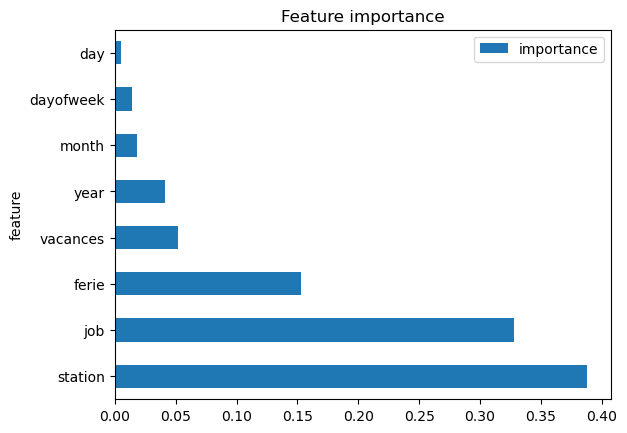

In [14]:
#feature importances
fi = pd.DataFrame({'feature': X_train.columns, 'importance': best_model.feature_importances_}).sort_values('importance', ascending=False)
fi.plot(kind='barh', x='feature', y='importance', title='Feature importance')

In [ ]:
# Predict using the trained model
y_pred = pd.DataFrame(index=X_test.index)
y_pred['y'] = best_model.predict(X_test).astype(int)
y_pred.to_csv(file_path + 'y_pred.csv')

Text(0.5, 1.0, 'Station 1J7')

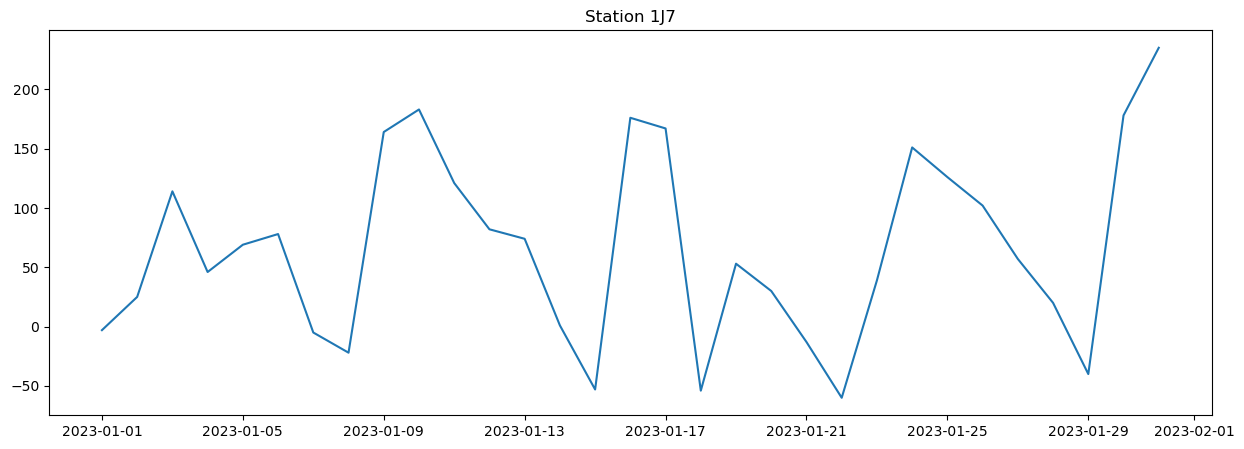

In [16]:
X_test2 = pd.read_csv(file_path + 'test_f_x_THurtzP.csv', index_col=0)
X_test2['date'] = pd.to_datetime(X_test2['date'])
X_plot = X_test2.loc[(X_test2.date < '2023-02-01') & (X_test2.station == '1J7')] #FIXME
plt.figure(figsize=(15, 5))
plt.plot(X_plot['date'], y_pred.loc[X_plot.index, 'y'])
plt.title('Station 1J7')